In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

torch.Size([64, 3, 256, 256])


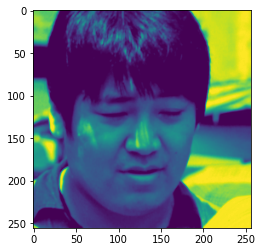

In [2]:
# load data

train_set = datasets.ImageFolder('./00000',transform=transforms.Compose([
                                                transforms.Resize([256,256]),
                                                transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# print(train_loader.shape)
for data, targets in train_loader:
    break
print(data.shape)
plt.imshow(data[0,0,:,:]*255)
plt.show()

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# G U-Net

# Conv block
class Conv(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Conv,self).__init__()

        # same size
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True)
        )
    
    def forward(self,x):
        return self.double_conv(x)

# Super resloution
class superR(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(superR,self).__init__()

        self.deConv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,in_channels,4,stride=2,padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2,inplace=True),

            nn.ConvTranspose2d(in_channels,out_channels,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        return self.deConv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()

        self.down1 = Conv(3,64)
        self.down2 = Conv(64,128)
        self.down3 = Conv(128,256)
        self.down4 = Conv(256,512)
     

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)

        
        self.up3 = Conv(256+512,256)
        self.up2 = Conv(128+256,128)
        self.up1 = Conv(64+128,64)

        # super resolution
        self.super = superR(64,3)

    def forward(self,x):
        # encode
        conv1 = self.down1(x)
        x = self.maxpool(conv1)
        # print('1',x.shape)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        # print('2',x.shape)

        conv3 = self.down3(x)
        x = self.maxpool(conv3)
        # print('3',x.shape)

        x = self.down4(x)
        # print('4',x.shape)

        # decode
        x = self.upsample(x)
        x = torch.cat([x,conv3],dim=1)
        x = self.up3(x)
        # print('5',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv2],dim=1)
        x = self.up2(x)
        # print('6',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv1],dim=1)
        x = self.up1(x)

        x = self.super(x)

        return x



In [5]:
# test shape

model = UNet()
x = torch.randn(1,3,64,64)
y = model(x)
print(y.shape)


torch.Size([1, 3, 256, 256])


In [6]:
# data preprocessing

# resize to 64 x 64
T = transforms.Resize(size=(64,64))
in_images = T(data)
print(in_images.shape)


torch.Size([64, 3, 64, 64])


In [7]:
# D patchGan

class Disc(nn.Module):
    def __init__(self):
        super(Disc,self).__init__()

        self.patchgan = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(128,256,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(256,512,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),

            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),

            
            
        )
        self.fc = nn.Linear(512*16*16,2)

    def forward(self,x):
        x = self.patchgan(x)
        # x = x.view(-1,512*16*16)
        # x = self.fc(x)
        return x


In [8]:
model = UNet()
x = torch.randn(1,3,64,64)
y = model(x)
print(y.shape)
model = Disc()
z = model(y)
print(z.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 16, 16])


In [9]:
flag_gpu = 1
# Batch size during training
batch_size = 64
# Number of training epochs
epochs = 50
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
G = UNet().to(device)
D = Disc().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)


GPU State: cuda:0


In [10]:
# Train
L1_loss = nn.L1Loss().to(device)
BCE_loss = nn.BCEWithLogitsLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

       
        #  ---------Train Generator-------------------------
        
        g_optimizer.zero_grad()
        # Sample noise as generator input
        # noise = torch.randn(images.shape[0], latent_dim, 1, 1) 
        # # G input
        g_images = T(images)
        noise = g_images.to(device)
        
        # fake_label 
        
        # Generate a batch of images
        fake_inputs = G(noise)
        # print(fake_inputs.shape)
        # print(fake_inputs.shape)
        fake_outputs = D(fake_inputs)
        # print(fake_outputs.shape)
        fake_label = torch.ones(fake_outputs.shape, dtype=torch.long).to(device) # notice: label = 1
        # print(fake_label.shape)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = L1_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        

        
        # -------------Train Discriminator----------------
        # Zero the parameter gradients
        # if epoch%3 == 1:
        d_optimizer.zero_grad()
        
        real_inputs = images.to(device) 
        real_label = torch.ones(fake_outputs.shape, dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_outputs.shape, dtype=torch.long).to(device)
#       learning by Discriminator
        # print('test',real_label.shape)
        # print(D(real_inputs).shape)
        real_loss = BCE_loss(D(real_inputs).float(),real_label.float())
        fake_loss = BCE_loss(D(fake_inputs.detach()).float(),fake_label.float())

        loss_d_value = (real_loss + fake_loss) / 2
    
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    g_scheduler.step()
    d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    print('Cost Time: {}s'.format(time.time()-start_time))
    
        
#         plt.show()

torch.save(G.state_dict(), 'pix2pix_Generator.pth')
torch.save(D.state_dict(), 'pix2pix_Discriminator.pth')
print('Model saved.')

print('Training Finished.')

[Epoch: 1/50] D_loss: 0.467 G_loss: 1.485
Cost Time: 52.37273597717285s
[Epoch: 2/50] D_loss: 0.635 G_loss: 0.712
Cost Time: 103.68863439559937s
[Epoch: 3/50] D_loss: 0.687 G_loss: 0.951
Cost Time: 155.0698482990265s
[Epoch: 4/50] D_loss: 0.675 G_loss: 0.936
Cost Time: 206.429927110672s
[Epoch: 5/50] D_loss: 0.683 G_loss: 0.935
Cost Time: 257.92019748687744s
[Epoch: 6/50] D_loss: 0.679 G_loss: 0.997
Cost Time: 309.33992409706116s
[Epoch: 7/50] D_loss: 0.655 G_loss: 0.968
Cost Time: 360.6412925720215s
[Epoch: 8/50] D_loss: 0.654 G_loss: 0.984
Cost Time: 412.0187873840332s
[Epoch: 9/50] D_loss: 0.633 G_loss: 0.970
Cost Time: 463.5230801105499s
[Epoch: 10/50] D_loss: 0.638 G_loss: 1.358
Cost Time: 515.2070333957672s
[Epoch: 11/50] D_loss: 0.626 G_loss: 0.919
Cost Time: 567.5372116565704s
[Epoch: 12/50] D_loss: 0.632 G_loss: 0.998
Cost Time: 620.0263764858246s
[Epoch: 13/50] D_loss: 0.606 G_loss: 0.999
Cost Time: 672.5892245769501s
[Epoch: 14/50] D_loss: 0.662 G_loss: 0.934
Cost Time: 725.